In [1]:
pip install ISLP

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
from statsmodels.datasets import get_rdataset
from ISLP import load_data , confusion_table

In [50]:
df = pd.read_csv('dataQTM.csv')
df = df.drop(['id', 'Unnamed: 32'], axis=1)
Diagnosis = df['diagnosis']

In [51]:
from sklearn.tree import DecisionTreeClassifier as DTC
from ISLP.models import ModelSpec as MS

In [52]:
model = MS(df.columns.drop('diagnosis'), intercept=False)
D = model.fit_transform(df)
feature_names = list(D.columns)
X = np.asarray(D)

In [53]:
clf = DTC(criterion='entropy',
          max_depth=3,
          random_state=123)

clf.fit(X, Diagnosis)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=123)

In [54]:
from sklearn.metrics import accuracy_score

In [55]:
# This is prediction accuracy
accuracy_score(Diagnosis, clf.predict(X))

0.968365553602812

In [56]:
from sklearn.metrics import log_loss

In [57]:
# deviance, the smaller, the better
resid_dev = np.sum(log_loss(Diagnosis, clf.predict_proba(X)))
resid_dev

0.08517045624888883

In [58]:
from matplotlib.pyplot import subplots
from sklearn.tree import plot_tree

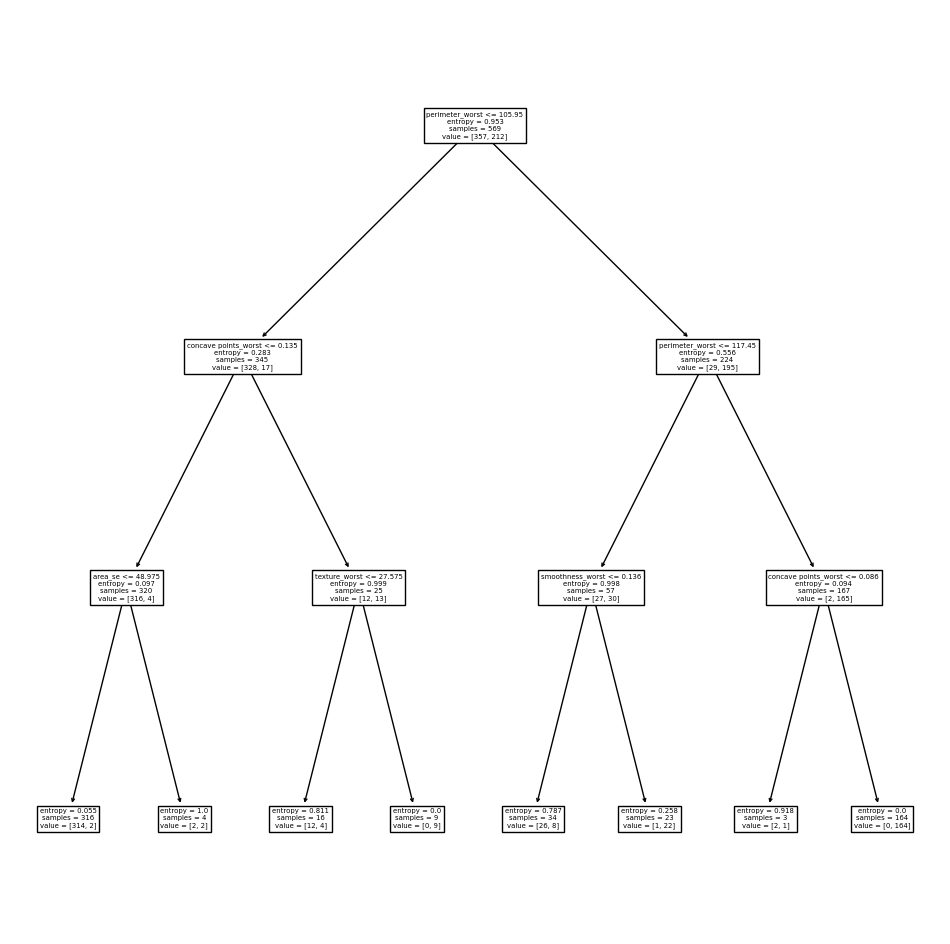

In [59]:
#most important feature in predicting diagnosis: perimeter_worst
ax = subplots(figsize=(12,12))[1]
plot_tree(clf,
          feature_names=feature_names,
          ax=ax);

In [60]:
from sklearn.tree import export_text

In [61]:
print(export_text(clf,
                  feature_names=feature_names,
                  show_weights=True))

|--- perimeter_worst <= 105.95
|   |--- concave points_worst <= 0.14
|   |   |--- area_se <= 48.98
|   |   |   |--- weights: [314.00, 2.00] class: B
|   |   |--- area_se >  48.98
|   |   |   |--- weights: [2.00, 2.00] class: B
|   |--- concave points_worst >  0.14
|   |   |--- texture_worst <= 27.58
|   |   |   |--- weights: [12.00, 4.00] class: B
|   |   |--- texture_worst >  27.58
|   |   |   |--- weights: [0.00, 9.00] class: M
|--- perimeter_worst >  105.95
|   |--- perimeter_worst <= 117.45
|   |   |--- smoothness_worst <= 0.14
|   |   |   |--- weights: [26.00, 8.00] class: B
|   |   |--- smoothness_worst >  0.14
|   |   |   |--- weights: [1.00, 22.00] class: M
|   |--- perimeter_worst >  117.45
|   |   |--- concave points_worst <= 0.09
|   |   |   |--- weights: [2.00, 1.00] class: B
|   |   |--- concave points_worst >  0.09
|   |   |   |--- weights: [0.00, 164.00] class: M



In [62]:
import sklearn.model_selection as skm

In [63]:
#correct prediction percentage 94%

validation = skm.ShuffleSplit(n_splits=1,
                              test_size=200,
                              random_state=123)
results = skm.cross_validate(clf,
                             D,
                             Diagnosis,
                             cv=validation)
results['test_score']

array([0.95])

In [64]:
#split: 70% training set and 30% testing set
(X_train, X_test, y_train, y_test) = skm.train_test_split(X, Diagnosis, test_size=0.3, random_state=123)

In [67]:
#refit the full tree on the training set with no set max_depth parameter
clf = DTC(criterion='entropy', random_state=123) 
clf.fit(X_train, y_train)
accuracy_score(y_test, clf.predict(X_test))

0.9415204678362573

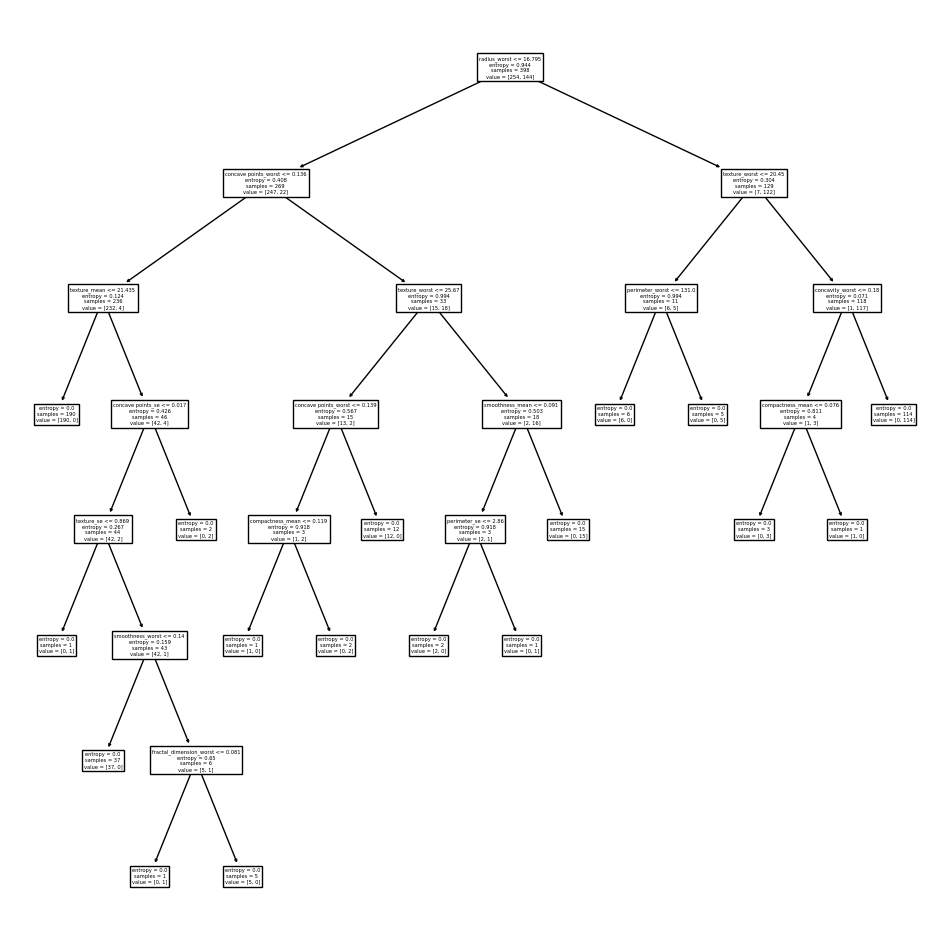

In [68]:
#generate the tree
ax = subplots(figsize=(12,12))[1] 
plot_tree(clf,
          feature_names=feature_names, 
          ax=ax);

In [70]:
#use cost_complexity_prunning_path() method of clf to extract cost-complexity values
ccp_path = clf.cost_complexity_pruning_path(X_train, y_train) 
kfold = skm.KFold(10, random_state=123, shuffle=True)

In [71]:
#set the grid to fit the optimal parameter by cross validation
grid = skm.GridSearchCV(clf, 
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy') 
grid.fit(X_train, y_train)
grid.best_score_

0.9348717948717947

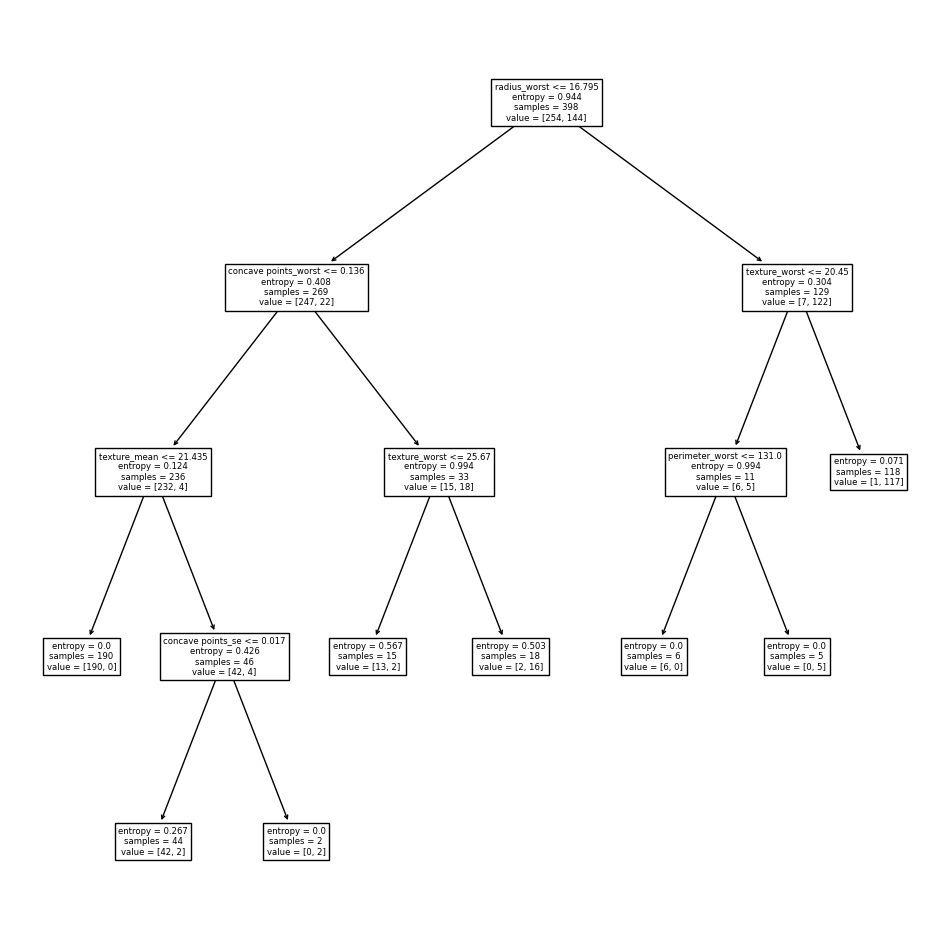

In [72]:
#generate the prunned tree
ax = subplots(figsize=(12, 12))[1] 
best_ = grid.best_estimator_ 
plot_tree(best_, 
          feature_names=feature_names, 
          ax=ax);

In [79]:
#print the confusion table
accuracy = accuracy_score(y_test, best_.predict(X_test))
confusion = confusion_table(best_.predict(X_test), 
                            y_test)
confusion

Truth,B,M
Predicted,,
B,100,6
M,3,62


In [81]:
misclassification_rate = 1 - accuracy
misclassification_rate

0.052631578947368474